In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pycbc
from pycbc.types import FrequencySeries
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform

from gstlal import chirptime
from functools import partial


import h5py
import scipy

import bilby
from bilby.gw import utils as gwutils
from pesummary.gw.conversions import spins as pespin
from multiprocessing import Pool
import multiprocessing
from functools import partial
from bilby.gw import conversion

import torch
import os
# cit: '/home/qian.hu/neuron_process_waveform/npf_GWwaveform'
# local: '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/'
os.chdir('/home/qian.hu/neuron_process_waveform/npf_GWwaveform')
from gw.utils import gwutils as npgwutils


In [133]:
duration=32/4
f_lower=10*2
sampling_frequency=4096/2
ifos = bilby.gw.detector.InterferometerList(['L1'])
det = ifos[0]
det.duration = duration
det.sampling_frequency=sampling_frequency
det.frequency_mask = det.frequency_array>=f_lower
mask = det.frequency_mask
freq_array = det.frequency_array[mask]

injection_parameters = {'chirp_mass': 20,
 'mass_ratio': 1,
 'a_1': 0.48817513918906,
 'a_2': 0.3618136183509149,
 'tilt_1': 1.5721118014736555,
 'tilt_2': 0.6209483780316792,
 'phi_12': 0.497541312882614,
 'phi_jl': 2.727769314864493,
 'theta_jn': 1.2076899194027677,
 'psi': 2.592123436585328,
 'phase': 3.153492039022807,
 'ra': 4.2400911,
 'dec': -0.39120439,
 'luminosity_distance': 320,
 'geocent_time': 1256779567.5339382}

approx = 'IMRPhenomPv2' # IMRPhenomXPHM IMRPhenomPv2
approx_under = 'SEOBNRv4P' # SEOBNRv4PHM SEOBNRv4
f_ref = 50
f_lower = 20
waveform_arguments = dict(waveform_approximant=approx,
                              reference_frequency=f_ref, minimum_frequency=f_lower)
waveform_arguments_under = dict(waveform_approximant=approx_under,
                              reference_frequency=f_ref, minimum_frequency=f_lower)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)

waveform_generator_under = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments_under)

In [134]:
h_dict_imr = waveform_generator.frequency_domain_strain(injection_parameters)
h_dict_eob = waveform_generator_under.frequency_domain_strain(injection_parameters)

In [146]:
# local
# PHM: '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_PHM_q25a8M40_2N10k/'
# P: '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_P_q25a8M40_2N10k/'

# cit
# PHM: '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_PHM_q25a8M40_2N10k/'
# P: '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_P_q25a8M40_2N10k/'
np_model_path = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_P_q25a8M40_2N10k/'
waveform_generator_np = npgwutils.NPWaveformGenerator(model_path=np_model_path,context_waveform_generator=waveform_generator,device='cpu')

waveform_generator_np2 = npgwutils.NPWaveformGenerator(model_path=np_model_path,context_waveform_generator=waveform_generator_under,device='cpu')


--- Loading plus_real/ConvCNP/run_0 ---

plus_real/ConvCNP/run_0 | best epoch: 88 | train loss: 6636.4643 | valid loss: 6205.1311 | test log likelihood: -10883.8718

--- Loading plus_imag/ConvCNP/run_0 ---

plus_imag/ConvCNP/run_0 | best epoch: 93 | train loss: 3173.7404 | valid loss: 2757.5753 | test log likelihood: -4424.3778

--- Loading cross_real/ConvCNP/run_0 ---

cross_real/ConvCNP/run_0 | best epoch: 95 | train loss: 5802.8842 | valid loss: 5674.4484 | test log likelihood: -7257.1511

--- Loading cross_imag/ConvCNP/run_0 ---

cross_imag/ConvCNP/run_0 | best epoch: 86 | train loss: 9247.2445 | valid loss: 8802.5473 | test log likelihood: -10386.1822

--- Loading plus_real/ConvCNP/run_0 ---

plus_real/ConvCNP/run_0 | best epoch: 88 | train loss: 6636.4643 | valid loss: 6205.1311 | test log likelihood: -10883.8718

--- Loading plus_imag/ConvCNP/run_0 ---

plus_imag/ConvCNP/run_0 | best epoch: 93 | train loss: 3173.7404 | valid loss: 2757.5753 | test log likelihood: -4424.3778

--

In [148]:
h_dict, error_dict = waveform_generator_np.frequency_domain_strain(injection_parameters)

h_dict2, error_dict2 = waveform_generator_np2.frequency_domain_strain(injection_parameters)

In [137]:

def my_inner_product(hf1,hf2,det,flag):
    inner_prod_complex = gwutils.noise_weighted_inner_product(
                            aa=hf1[det.strain_data.frequency_mask],
                            bb=hf2[det.strain_data.frequency_mask],
                            power_spectral_density=det.power_spectral_density_array[det.strain_data.frequency_mask],
                            duration=det.strain_data.duration)

    #inner_prod_complex = det.inner_product_2(hf1, hf2)
    if flag == "c":
        return inner_prod_complex
    elif flag == "r":
        return np.real(inner_prod_complex)
    else:
        raise("Wrong flag!")


def get_dtdphi_withift_zeropad(h1,h2,det):

    psd = det.power_spectral_density_array
    f_array = det.frequency_array
    
    X_of_f = h1*h2.conjugate()/psd
    add_zero = np.zeros(int(63*len(X_of_f)))
    X_of_f = np.append(X_of_f,add_zero)
    X_of_t = np.fft.ifft(X_of_f)
    
    timelength = 1/(f_array[1]-f_array[0])
    t = np.linspace(-timelength/2,timelength/2,len(X_of_t))
    X_shifted = np.roll(X_of_t,len(X_of_t)//2)

    jmax = np.argmax( abs(X_shifted) )
    deltat = t[jmax]
    phase1 = 2*np.pi*f_array*deltat
    
    freq_mask = det.strain_data.frequency_mask
    inner_product = my_inner_product(h1.conjugate(), h2.conjugate()*np.exp(1j*phase1), det, 'c')
    
    '''
    gwutils.noise_weighted_inner_product(
                    aa=h1.conjugate()[freq_mask],
                    bb=(h2.conjugate()*np.exp(1j*phase1))[freq_mask],
                    power_spectral_density=det.power_spectral_density_array[freq_mask],
                    duration=det.strain_data.duration)'''
    
    deltaphi = -np.angle(inner_product)
    #phase2 = deltaphi
    
    return deltat,deltaphi


def get_shifted_h2_zeropad(h1,h2,det):
    '''
    Return the h2*exp(-i*phase_shift), i.e. h2* exp -i*(2\pi f \Delta t + \Delta \phi)
    '''
    deltat,deltaphi = get_dtdphi_withift_zeropad(h1,h2,det)
    f_array = det.frequency_array
    exp_phase = np.exp(-1j*(2*np.pi*f_array*deltat + deltaphi) )
    return h2*exp_phase

    

In [138]:
for key in ['plus', 'cross']:
    h_dict_eob[key] = get_shifted_h2_zeropad(h_dict_imr[key], h_dict_eob[key], det)

(20.0, 40.0)

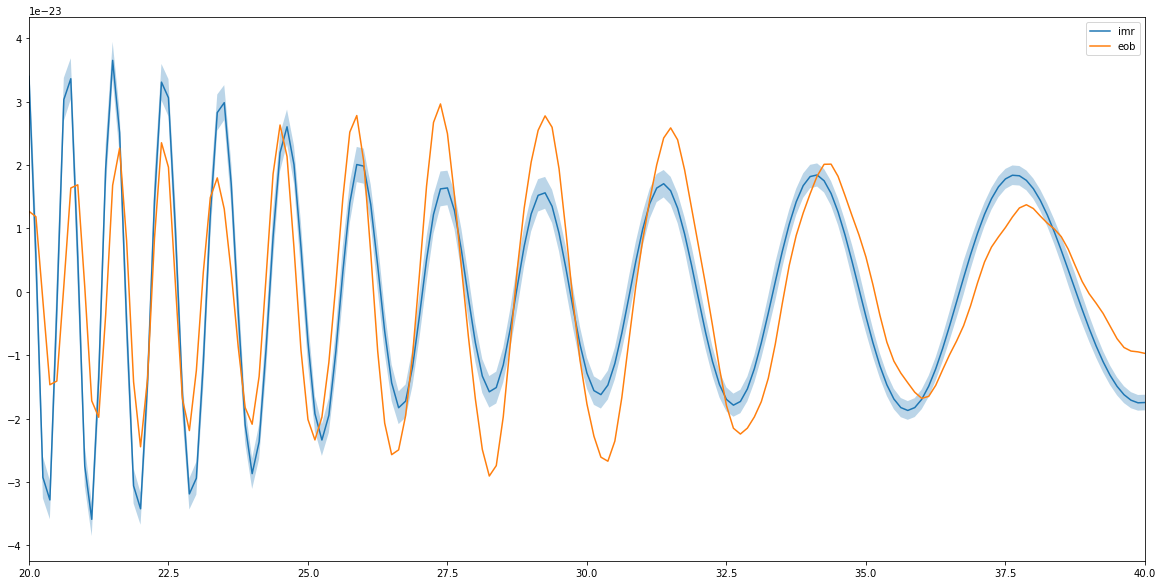

In [139]:
plt.figure(figsize=(20,10))

mode = 'cross'
'''
plt.plot(waveform_generator.frequency_array, np.real(h_dict[mode]), label='np')
plt.fill_between(waveform_generator.frequency_array,
                 np.real(h_dict[mode]-error_dict[mode]),np.real(h_dict[mode]+error_dict[mode]),
                 alpha=0.3 )
'''
plt.plot(waveform_generator.frequency_array, np.real(h_dict_imr[mode]), label='imr')
plt.fill_between(waveform_generator.frequency_array,
                 np.real(h_dict_imr[mode]-error_dict[mode]),np.real(h_dict_imr[mode]+error_dict[mode]),
                 alpha=0.3 )

plt.plot(waveform_generator.frequency_array, np.real(h_dict_eob[mode]), label='eob')

plt.legend()
#plt.xlim(40,100)
plt.xlim(20,40)

(20, 2000)

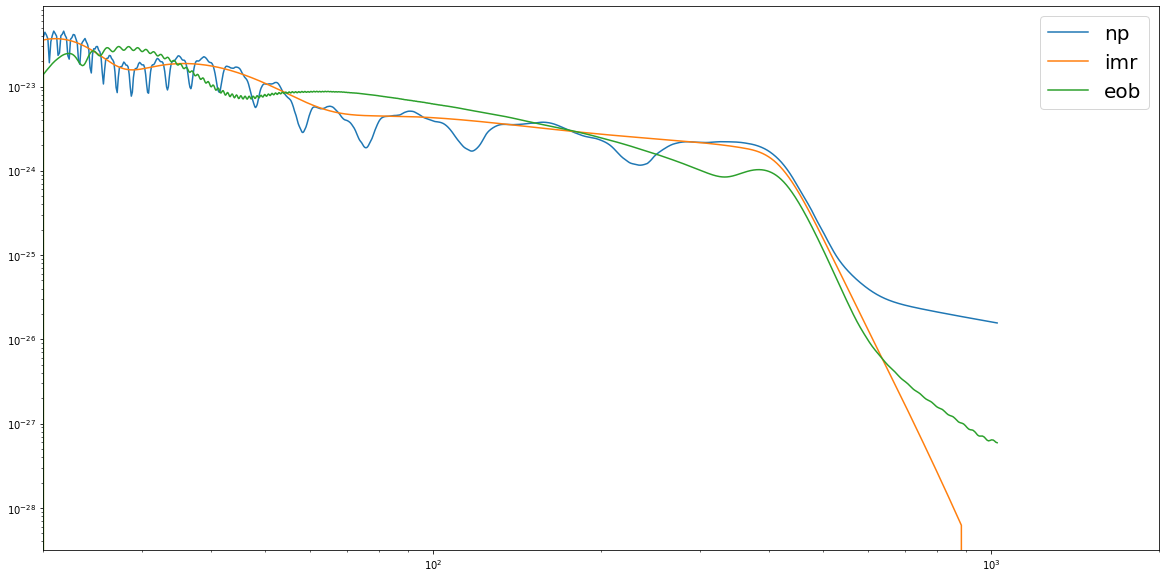

In [140]:
plt.figure(figsize=(20,10))

mode = 'cross'
plt.loglog(waveform_generator.frequency_array, np.abs(h_dict[mode]), label='np')
#plt.fill_between(waveform_generator.frequency_array,
#                 np.real(h_dict[mode]-error_dict[mode]),np.real(h_dict[mode]+error_dict[mode]),
#                 alpha=0.3 )

plt.loglog(waveform_generator.frequency_array, np.abs(h_dict_imr[mode]), label='imr')
#plt.fill_between(waveform_generator.frequency_array,
#                 np.real(h_dict_imr[mode]-error_dict[mode]),np.real(h_dict_imr[mode]+error_dict[mode]),
#                 alpha=0.3 )

plt.loglog(waveform_generator.frequency_array, np.abs(h_dict_eob[mode]), label='eob')

plt.legend(fontsize=20)
plt.xlim(20,2000)

(20.0, 100.0)

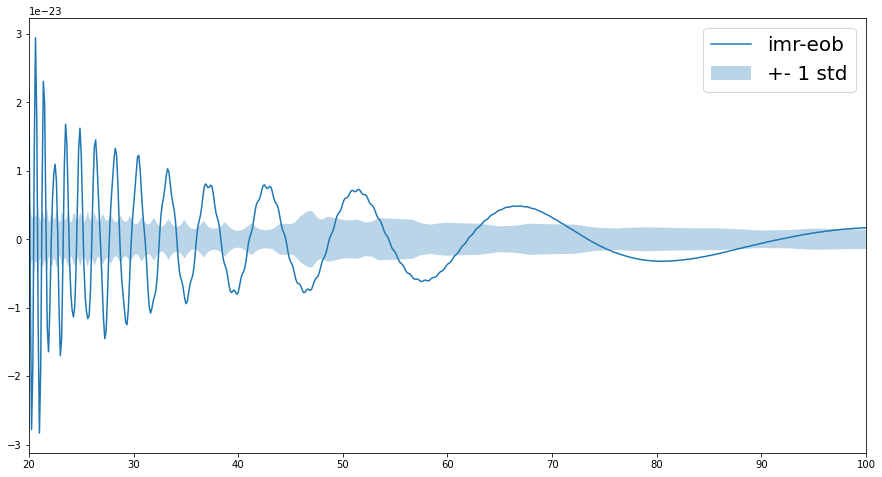

In [141]:
plt.figure(figsize=(15,8))

mode = 'cross'


plt.plot(waveform_generator.frequency_array, np.real(h_dict_imr[mode]-h_dict_eob[mode]), label='imr-eob')
nsigma = 1
plt.fill_between(waveform_generator.frequency_array, -nsigma*np.real(error_dict[mode]),nsigma*np.real(error_dict[mode]), label=f'+- {nsigma} std', alpha=0.3)


plt.legend(fontsize=20)
#plt.xlim(40,100)
plt.xlim(20,100)

(20.0, 50.0)

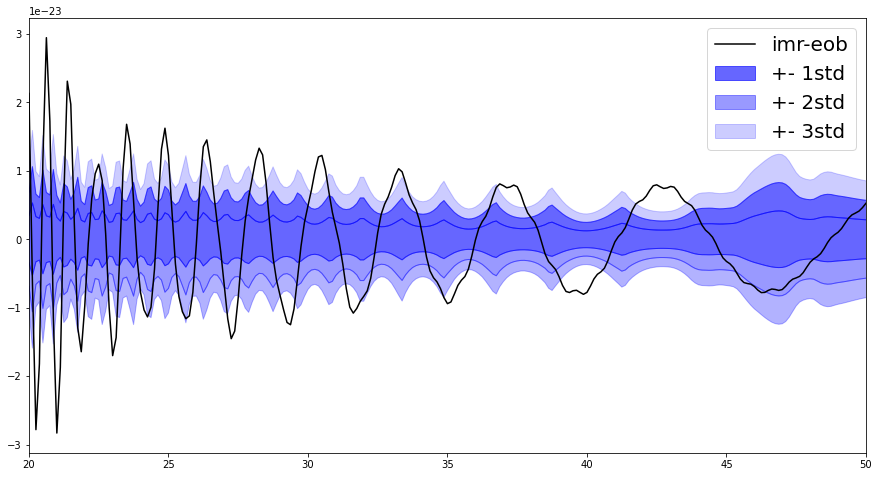

In [142]:
plt.figure(figsize=(15,8))

mode = 'cross'


plt.plot(waveform_generator.frequency_array, np.real(h_dict_imr[mode]-h_dict_eob[mode]), label='imr-eob', color='k')

plt.fill_between(waveform_generator.frequency_array, -np.real(error_dict[mode]),np.real(error_dict[mode]), label=f'+- 1std', alpha=0.6, color='b')

plt.fill_between(waveform_generator.frequency_array, -2*np.real(error_dict[mode]),-1*np.real(error_dict[mode]), label=f'+- 2std', alpha=0.4, color='b')
plt.fill_between(waveform_generator.frequency_array, np.real(error_dict[mode]),2*np.real(error_dict[mode]), alpha=0.6, color='b')

plt.fill_between(waveform_generator.frequency_array, -3*np.real(error_dict[mode]),-2*np.real(error_dict[mode]), alpha=0.3, color='b')
plt.fill_between(waveform_generator.frequency_array, 2*np.real(error_dict[mode]),3*np.real(error_dict[mode]), label=f'+- 3std', alpha=0.2, color='b')


plt.legend(fontsize=20)
#plt.xlim(40,100)
plt.xlim(20,50)

(20.0, 50.0)

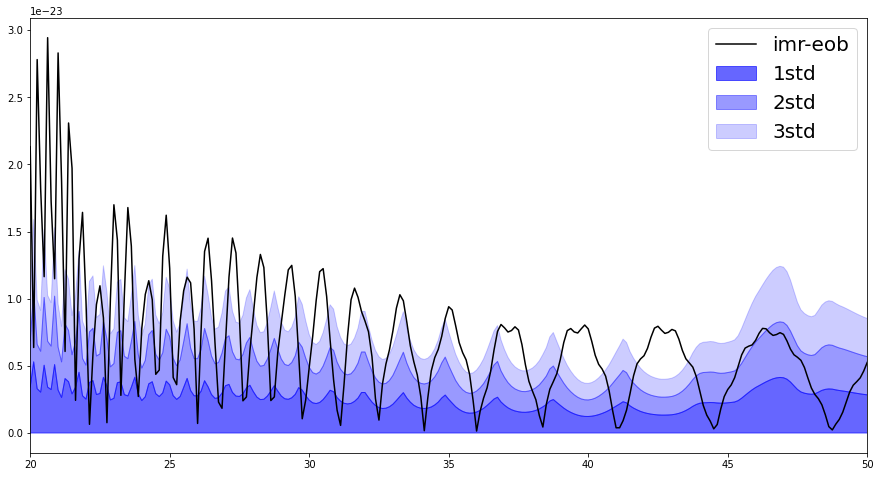

In [143]:
plt.figure(figsize=(15,8))

mode = 'cross'


plt.plot(waveform_generator.frequency_array, abs(np.real(h_dict_imr[mode]-h_dict_eob[mode])), label='imr-eob', color='k')

plt.fill_between(waveform_generator.frequency_array, np.zeros(len(waveform_generator.frequency_array)), np.real(error_dict[mode]), label=f'1std', alpha=0.6, color='b')

plt.fill_between(waveform_generator.frequency_array, np.real(error_dict[mode]),2*np.real(error_dict[mode]), alpha=0.4, color='b', label=f'2std')

plt.fill_between(waveform_generator.frequency_array, 2*np.real(error_dict[mode]),3*np.real(error_dict[mode]), label=f'3std', alpha=0.2, color='b')


plt.legend(fontsize=20)
#plt.xlim(40,100)
plt.xlim(20,50)

(20.0, 50.0)

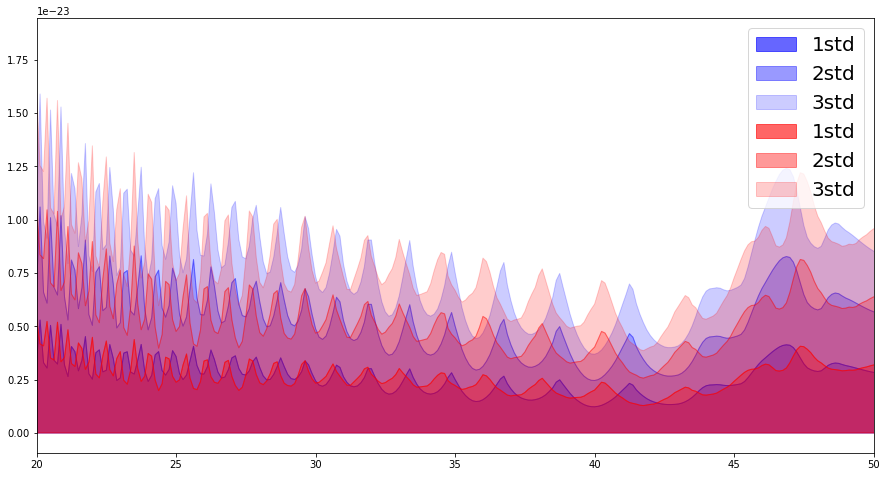

In [144]:
plt.figure(figsize=(15,8))

mode = 'cross'
plt.fill_between(waveform_generator.frequency_array, np.zeros(len(waveform_generator.frequency_array)), np.real(error_dict[mode]), label=f'1std', alpha=0.6, color='b')

plt.fill_between(waveform_generator.frequency_array, np.real(error_dict[mode]),2*np.real(error_dict[mode]), alpha=0.4, color='b', label=f'2std')

plt.fill_between(waveform_generator.frequency_array, 2*np.real(error_dict[mode]),3*np.real(error_dict[mode]), label=f'3std', alpha=0.2, color='b')


plt.fill_between(waveform_generator.frequency_array, np.zeros(len(waveform_generator.frequency_array)), np.real(error_dict2[mode]), label=f'1std', alpha=0.6, color='r')

plt.fill_between(waveform_generator.frequency_array, np.real(error_dict2[mode]),2*np.real(error_dict2[mode]), alpha=0.4, color='r', label=f'2std')

plt.fill_between(waveform_generator.frequency_array, 2*np.real(error_dict2[mode]),3*np.real(error_dict2[mode]), label=f'3std', alpha=0.2, color='r')


plt.legend(fontsize=20)
#plt.xlim(40,100)
plt.xlim(20,50)

In [145]:
len(waveform_generator.frequency_array,)

8193